In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
import warnings

warnings.filterwarnings("ignore")

In [18]:
# Training Data
train_dir = Path('../input/fruit-and-vegetable-image-recognition/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

# Test Data
test_dir = Path('../input/fruit-and-vegetable-image-recognition/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

# Validation Data
val_dir = Path('../input/fruit-and-vegetable-image-recognition/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

In [19]:
def image_processing(filepath):
    # Create a DataFrame with the filepath and the labels of the pictures

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [20]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)
print("Training Set")
print("Number of Pictures: ",train_df.shape[0])
print("Number of Crops: ", len(train_df.Label.unique()))
print("Labels: ",train_df.Label.unique())

Training Set
Number of Pictures:  2780
Number of Crops:  36
Labels:  ['corn' 'cucumber' 'pomegranate' 'garlic' 'jalepeno' 'mango' 'paprika'
 'grapes' 'cauliflower' 'sweetpotato' 'apple' 'spinach' 'watermelon'
 'carrot' 'capsicum' 'lettuce' 'eggplant' 'pineapple' 'ginger' 'raddish'
 'bell pepper' 'cabbage' 'beetroot' 'soy beans' 'potato' 'pear'
 'sweetcorn' 'peas' 'tomato' 'turnip' 'kiwi' 'orange' 'lemon' 'onion'
 'chilli pepper' 'banana']


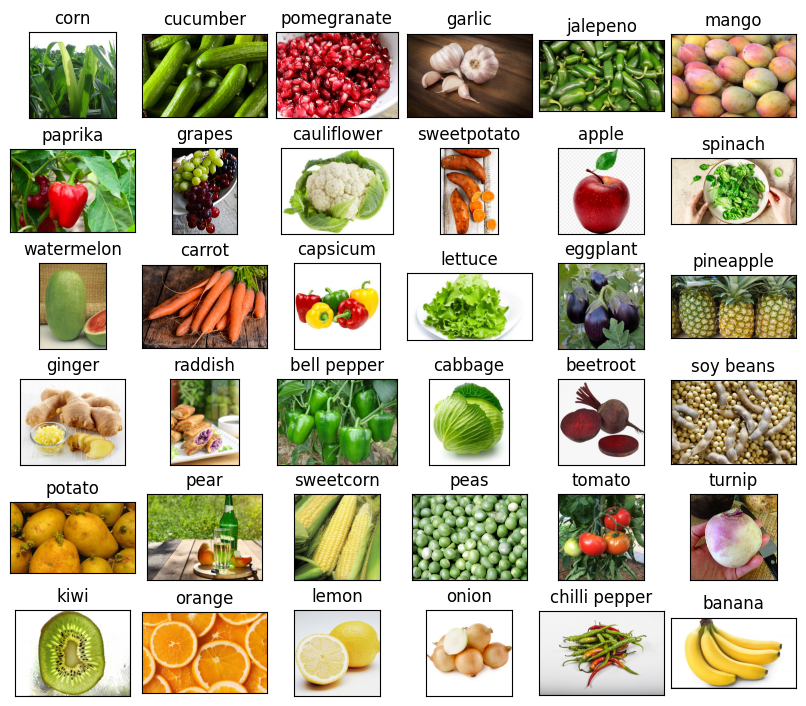

In [21]:
train_df.head(5)

# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [22]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [23]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2780 validated image filenames belonging to 36 classes.


In [24]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 334 validated image filenames belonging to 36 classes.


In [25]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 334 validated image filenames belonging to 36 classes.


In [26]:
# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(36, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
# Train the model and record training time for each epoch
import time

training_times = []
for epoch in range(5):
    start_time = time.time()
    history = model.fit(
        train_images,
        validation_data=val_images,
        batch_size=32,
        epochs=1,
        verbose=1
    )
    end_time = time.time()
    training_times.append(end_time - start_time)

87/87 [==============================] - 216s 2s/step - loss: 0.9837 - accuracy: 0.7140 - val_loss: 0.3102 - val_accuracy: 0.9491


In [28]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred1 = [labels[k] for k in pred]

11/11 [==============================] - 19s 2s/step


In [29]:
# Calculate accuracy and error
accuracy = np.mean(pred == test_images.labels)
error = 1 - accuracy

# Create a confusion matrix
confusion = confusion_matrix(test_images.labels, pred)

# Print classification report
classification_rep = classification_report(test_images.labels, pred, target_names=test_images.class_indices.keys())

In [30]:
# Print metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Error Rate: {error * 100:.2f}%")
print(f"Training Times for Each Epoch: {training_times} seconds")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_rep)

Accuracy: 94.91%
Error Rate: 5.09%
Training Times for Each Epoch: [226.4038679599762, 262.8556354045868, 262.564120054245, 262.59091567993164, 216.99157452583313] seconds
Confusion Matrix:
[[ 6  0  0 ...  1  0  0]
 [ 0  8  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 10]]
Classification Report:
               precision    recall  f1-score   support

        apple       0.86      0.67      0.75         9
       banana       1.00      0.89      0.94         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.82      1.00      0.90         9
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.89      0.94         9
       carrot       1.00      1.00      1.00         7
  cauliflower       1.00      1.00      1.00         9
chilli pepper       0.88      1.00      0.93         7
         corn       0.83      1.00      0.91        10
     cucumber       1.00  

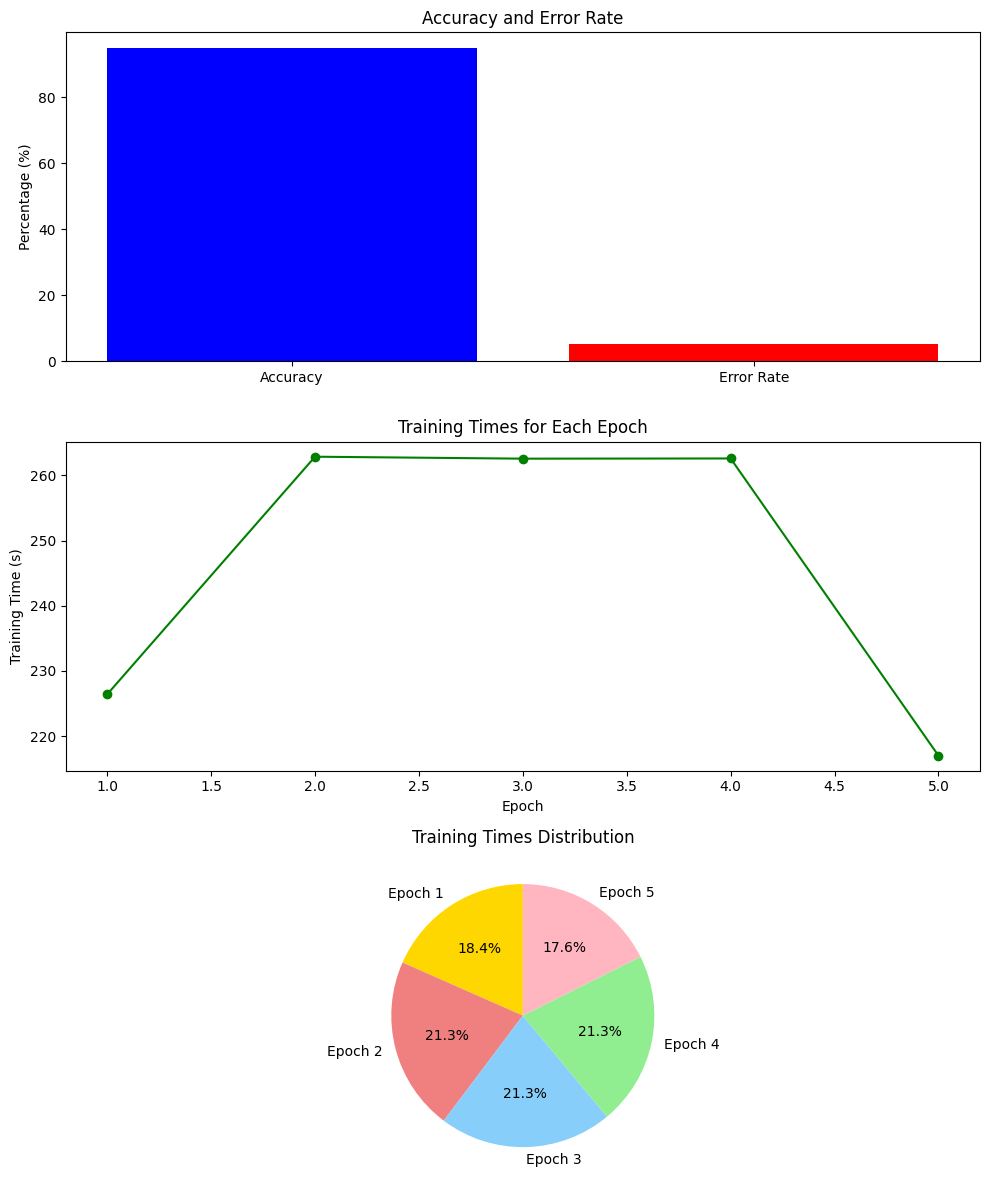

In [43]:
import matplotlib.pyplot as plt

# Accuracy and Error Rate
accuracy = 94.91
error_rate = 5.09

# Training Times for Each Epoch
training_times = [226.40, 262.86, 262.56, 262.59, 216.99]  # In seconds

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Accuracy and Error Rate Plot
ax1.bar(['Accuracy', 'Error Rate'], [accuracy, error_rate], color=['blue', 'red'])
ax1.set_ylabel('Percentage (%)')
ax1.set_title('Accuracy and Error Rate')

# Training Times Plot
ax2.plot(range(1, len(training_times) + 1), training_times, marker='o', linestyle='-', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Training Time (s)')
ax2.set_title('Training Times for Each Epoch')

# Pie Chart for Training Times
ax3.pie(training_times, labels=[f'Epoch {i+1}' for i in range(len(training_times))], autopct='%1.1f%%',
        startangle=90, colors=['gold', 'lightcoral', 'lightskyblue', 'lightgreen', 'lightpink'])
ax3.set_title('Training Times Distribution')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()


['precision    recall  f1-score   support', '', '       apple       0.86      0.67      0.75         9', '      banana       1.00      0.89      0.94         9', '    beetroot       1.00      1.00      1.00        10', ' bell_pepper       0.82      1.00      0.90         9', '     cabbage       1.00      1.00      1.00        10', '    capsicum       1.00      0.89      0.94         9', '      carrot       1.00      1.00      1.00         7', ' cauliflower       1.00      1.00      1.00         9', 'chilli_pepper    0.88      1.00      0.93         7', '         corn    0.83      1.00      0.91        10', '     cucumber    1.00      1.00      1.00        10', '     eggplant    1.00      1.00      1.00        10', '       garlic    1.00      1.00      1.00        10', '       ginger    1.00      0.90      0.95        10', '       grapes    1.00      1.00      1.00         8', '     jalepeno    1.00      1.00      1.00         9', '         kiwi    1.00      1.00      1.00        10', '

/tmp/ipykernel_33/838380207.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(class_names, rotation=90)
/tmp/ipykernel_33/838380207.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(class_names, rotation=90)
/tmp/ipykernel_33/838380207.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(class_names, rotation=90)


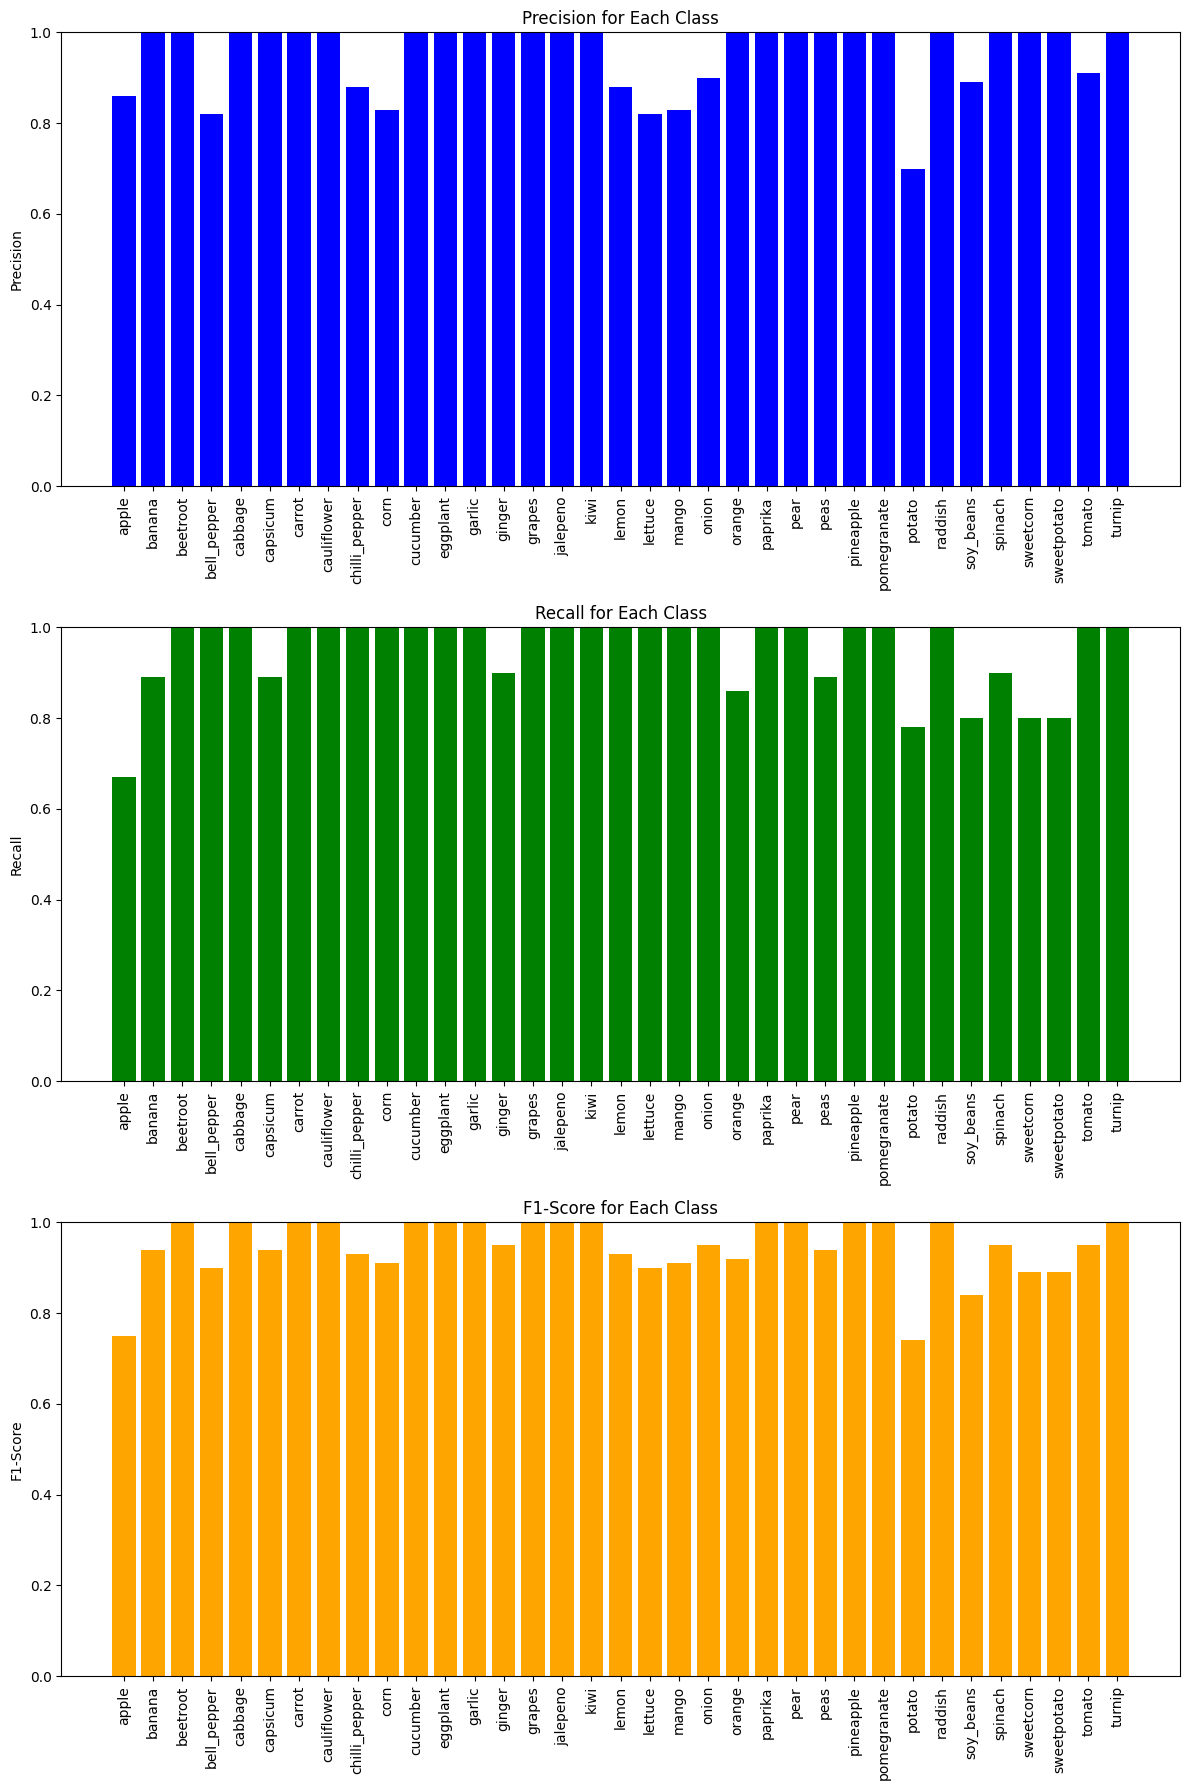

In [3]:
classification_rep_str = '''
              precision    recall  f1-score   support

       apple       0.86      0.67      0.75         9
      banana       1.00      0.89      0.94         9
    beetroot       1.00      1.00      1.00        10
 bell_pepper       0.82      1.00      0.90         9
     cabbage       1.00      1.00      1.00        10
    capsicum       1.00      0.89      0.94         9
      carrot       1.00      1.00      1.00         7
 cauliflower       1.00      1.00      1.00         9
chilli_pepper    0.88      1.00      0.93         7
         corn    0.83      1.00      0.91        10
     cucumber    1.00      1.00      1.00        10
     eggplant    1.00      1.00      1.00        10
       garlic    1.00      1.00      1.00        10
       ginger    1.00      0.90      0.95        10
       grapes    1.00      1.00      1.00         8
     jalepeno    1.00      1.00      1.00         9
         kiwi    1.00      1.00      1.00        10
        lemon    0.88      1.00      0.93         7
      lettuce    0.82      1.00      0.90         9
        mango    0.83      1.00      0.91        10
        onion    0.90      1.00      0.95         9
       orange    1.00      0.86      0.92         7
      paprika    1.00      1.00      1.00        10
         pear    1.00      1.00      1.00        10
         peas    1.00      0.89      0.94         9
    pineapple    1.00      1.00      1.00        10
  pomegranate    1.00      1.00      1.00        10
       potato    0.70      0.78      0.74         9
      raddish    1.00      1.00      1.00         8
    soy_beans    0.89      0.80      0.84        10
      spinach    1.00      0.90      0.95        10
    sweetcorn    1.00      0.80      0.89        10
  sweetpotato    1.00      0.80      0.89        10
       tomato    0.91      1.00      0.95        10
       turnip    1.00      1.00      1.00        10
   watermelon    1.00      1.00      1.00        10

     accuracy                           0.95       334
    macro avg       0.95      0.95      0.95       334
 weighted avg       0.95      0.95      0.95       334'''


# Split the classification report into lines
lines = classification_rep_str.strip().split('\n')
print(lines)

# Extract class names and metrics into dictionaries
class_names = []
metrics = {
    'precision': [],
    'recall': [],
    'f1-score': []
}

for line in lines[2:-5]:  # Exclude header and footer
    parts = line.split()
    print(parts)
    class_name = parts[0]
    class_names.append(class_name)
    metrics['precision'].append(float(parts[1]))
    metrics['recall'].append(float(parts[2]))
    metrics['f1-score'].append(float(parts[3]))

# Create bar plots for precision, recall, and F1-score
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

ax1.bar(class_names, metrics['precision'], color='blue')
ax1.set_ylabel('Precision')
ax1.set_ylim(0, 1)
ax1.set_xticklabels(class_names, rotation=90)
ax1.set_title('Precision for Each Class')

ax2.bar(class_names, metrics['recall'], color='green')
ax2.set_ylabel('Recall')
ax2.set_ylim(0, 1)
ax2.set_xticklabels(class_names, rotation=90)
ax2.set_title('Recall for Each Class')

ax3.bar(class_names, metrics['f1-score'], color='orange')
ax3.set_ylabel('F1-Score')
ax3.set_ylim(0, 1)
ax3.set_xticklabels(class_names, rotation=90)
ax3.set_title('F1-Score for Each Class')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
confusion = confusion_matrix(test_images.labels, pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'test_images' is not defined

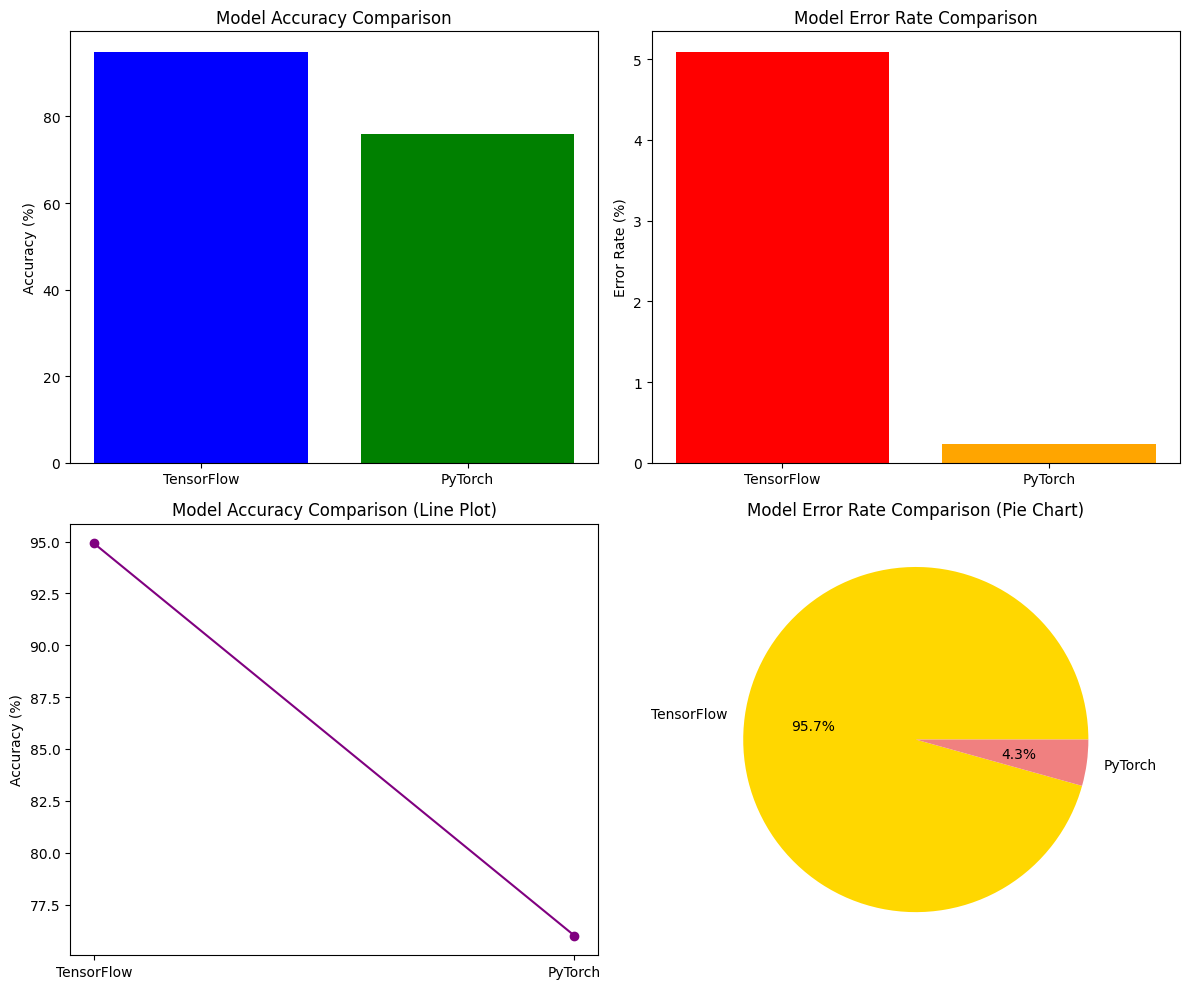

In [5]:
import matplotlib.pyplot as plt

# Model names
models = ['TensorFlow', 'PyTorch']

# Accuracy values
accuracy = [94.91, 76]

# Error rate values
error_rate = [5.09, 0.23]

# Create subplots for different plot types
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Bar chart for accuracy
axs[0, 0].bar(models, accuracy, color=['blue', 'green'])
axs[0, 0].set_ylabel('Accuracy (%)')
axs[0, 0].set_title('Model Accuracy Comparison')

# Plot 2: Bar chart for error rate
axs[0, 1].bar(models, error_rate, color=['red', 'orange'])
axs[0, 1].set_ylabel('Error Rate (%)')
axs[0, 1].set_title('Model Error Rate Comparison')

# Plot 3: Line plot for accuracy
axs[1, 0].plot(models, accuracy, marker='o', linestyle='-', color='purple')
axs[1, 0].set_ylabel('Accuracy (%)')
axs[1, 0].set_title('Model Accuracy Comparison (Line Plot)')

# Plot 4: Pie chart for error rate
axs[1, 1].pie(error_rate, labels=models, autopct='%1.1f%%', colors=['gold', 'lightcoral'])
axs[1, 1].set_title('Model Error Rate Comparison (Pie Chart)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


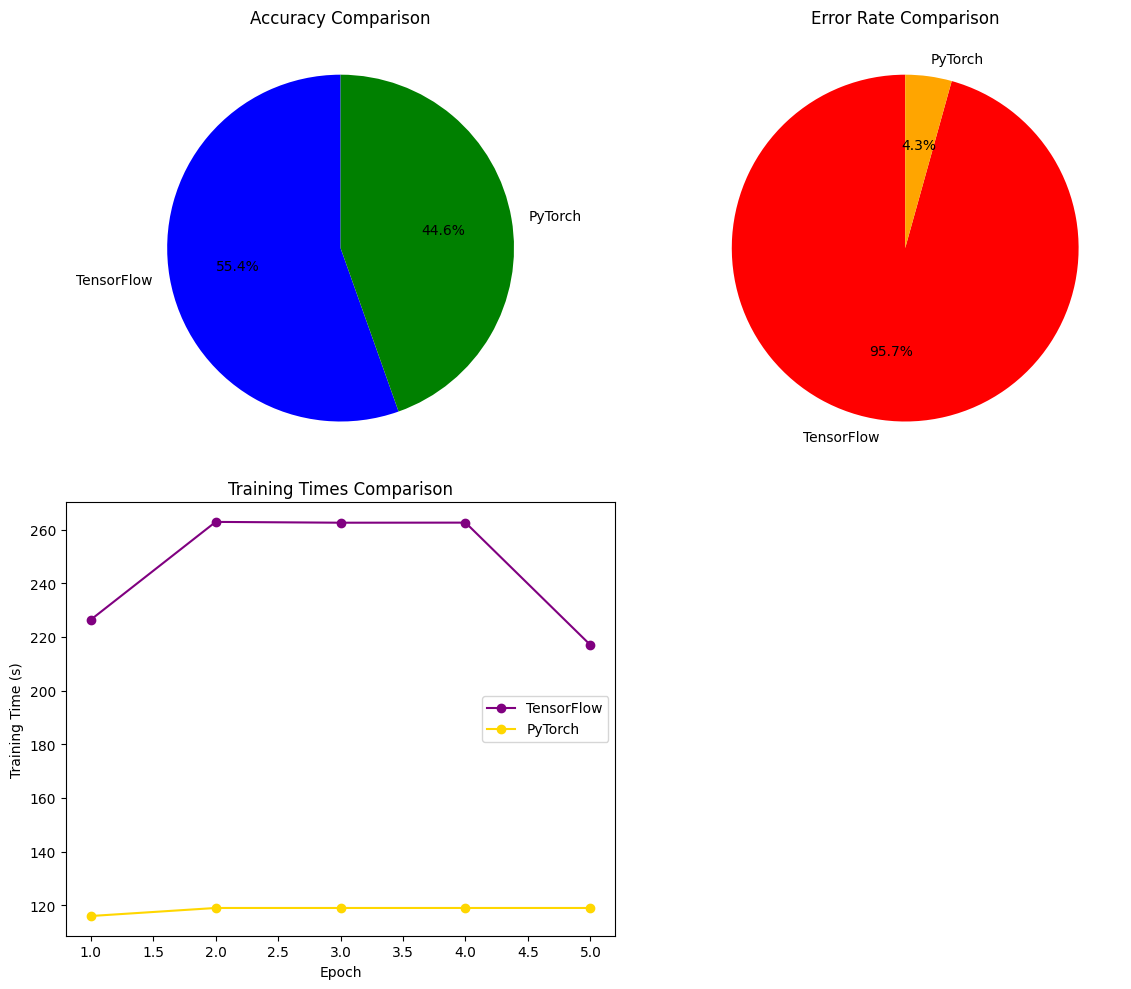

In [2]:
import matplotlib.pyplot as plt

# Model names
model_names = ['TensorFlow', 'PyTorch']

# Accuracy values for both models
accuracy_values = [94.91, 76.32]

# Error rate values for both models
error_rate_values = [5.09, 0.23]

# Training times for both models
training_times_model1 = [226.40, 262.86, 262.56, 262.59, 216.99]
training_times_model2 = [116, 119, 119, 119, 119]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot 3: Line plot for training times comparison
epochs = range(1, len(training_times_model1) + 1)
axs[1, 0].plot(epochs, training_times_model1, marker='o', linestyle='-', color='purple', label='TensorFlow')
axs[1, 0].plot(epochs, training_times_model2, marker='o', linestyle='-', color='gold', label='PyTorch')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Training Time (s)')
axs[1, 0].set_title('Training Times Comparison')
axs[1, 0].legend()

# Remove the empty subplot
fig.delaxes(axs[1, 1])

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


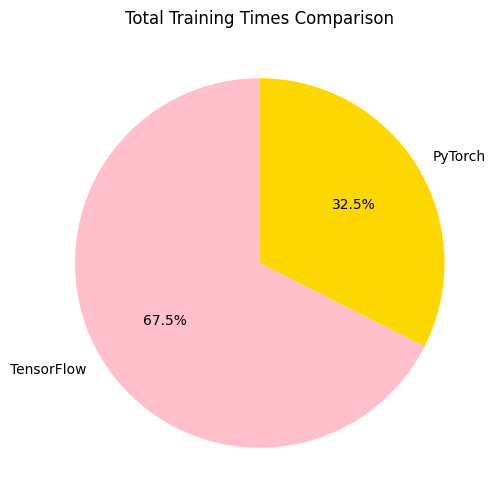

In [4]:
import matplotlib.pyplot as plt

# Model names
model_names = ['TensorFlow', 'PyTorch']

# Training times for both models
training_times_model1 = [226.40, 262.86, 262.56, 262.59, 216.99]
training_times_model2 = [116, 119, 119, 119, 119]

# Calculate the total training time for each model
total_training_time_model1 = sum(training_times_model1)
total_training_time_model2 = sum(training_times_model2)

# Combine the total training times
total_training_times = [total_training_time_model1, total_training_time_model2]

# Create a pie chart for training times
plt.figure(figsize=(8, 6))
plt.pie(total_training_times, labels=model_names, autopct='%1.1f%%', startangle=90, colors=['pink', 'gold'])
plt.title('Total Training Times Comparison')
plt.show()


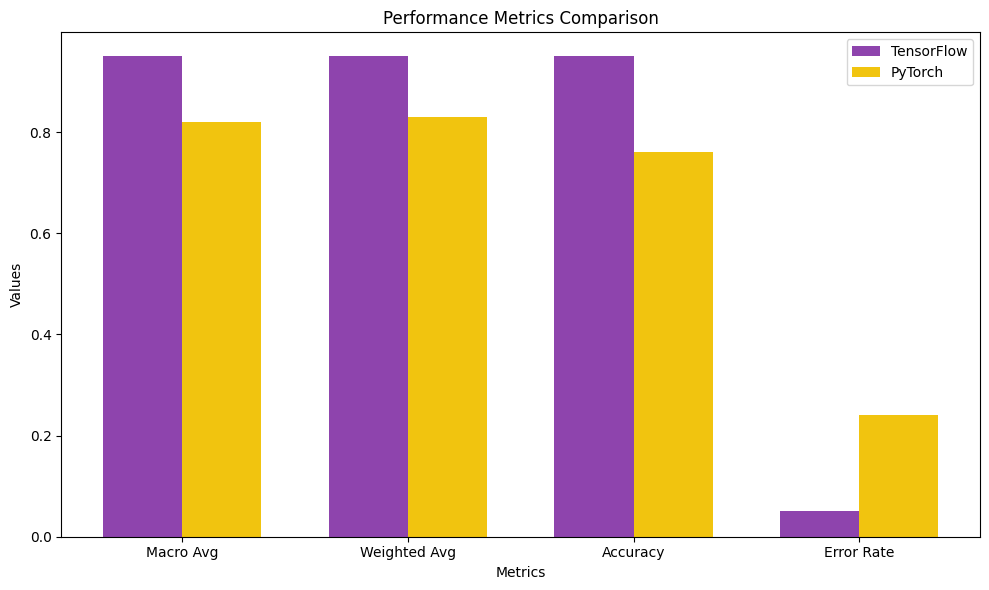

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and model names
metrics = ['Macro Avg', 'Weighted Avg', 'Accuracy', 'Error Rate']
model_names = ['TensorFlow', 'PyTorch']

# Values for each metric and model
values = np.array([
    [0.95, 0.82],
    [0.95, 0.83],
    [0.95, 0.76],
    [0.05, 0.24]
])

# Set the width of each bar
bar_width = 0.35
index = np.arange(len(metrics))

# Define light colors
colors = ['#8E44AD', '#F1C40F']

# Create grouped bar chart with light colors
fig, ax = plt.subplots(figsize=(10, 6))

for i, model_name in enumerate(model_names):
    ax.bar(index + i * bar_width, values[:, i], bar_width, label=model_name, color=colors[i])

# Set labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Performance Metrics Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
